In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib as plt
import sqlite3 as sql

db = gpd.read_file("RJ.json")

db.head()

,id,name,description,geometry
0,3300100,Angra dos Reis,Angra dos Reis,"POLYGON ((-44.19557 -23.09831, -44.19445 -23.1..."
1,3300159,Aperibé,Aperibé,"POLYGON ((-42.11517 -21.60398, -42.11585 -21.6..."
2,3300209,Araruama,Araruama,"POLYGON ((-42.18220 -22.55217, -42.13226 -22.6..."
3,3300225,Areal,Areal,"POLYGON ((-43.05873 -22.18937, -43.04773 -22.2..."
4,3300233,Armação dos Búzios,Armação dos Búzios,"POLYGON ((-41.93436 -22.76580, -41.91900 -22.7..."


<AxesSubplot:>

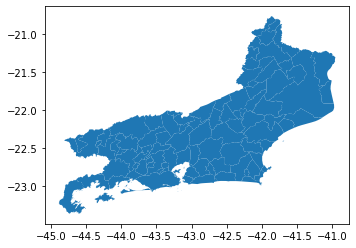

In [2]:
db.plot()